In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import cv2
import numpy as np
import pandas as pd
import os
import joblib
from tqdm import tqdm
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score 
import joblib
import pickle
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [10]:
random_seed =42

In [12]:
# Load metadata
df = pd.read_csv("/content/drive/MyDrive/trainLabels_cropped.csv")
image_names = df['image']
y = df['level']

subject0 = df.loc[ df['level']==0][0:10000]
subject1 = df.loc[ df['level']==1]
subject2 = df.loc[ df['level']==2]
subject3 = df.loc[ df['level']==3]
subject4 = df.loc[ df['level']==4]

# drop class 0 to 10000, remake the data frame object
df = pd.concat( (subject0, subject1, subject2, subject3, subject4), axis=0, ignore_index=True )
y = df['level']

# Merge class 1, 2, 3, 4 to class 1. Make a binary classification tesk.
for i in range(len(y)):
  if y[i] == 4 or y[i] == 1 or y[i] == 2 or y[i] == 3:
    y[i] = 1

# reload meta data
image_names = df['image']
index = np.arange(len(y))

# load grayscaled images
X_gray = joblib.load("/content/drive/MyDrive/X_gray")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
# NOTE: This block was used to preprocess images.

# Resize image to (256, 256, 3) and save it in X
# images = []
# for image in tqdm(image_names):
#     img = cv2.imread(f'archive\\resized_train_cropped\\resized_train_cropped\\{image}.jpeg')
#     img = cv2.resize(img, (256,256))
#     img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

#     if img is not None:
#         images.append(img)
# X = np.array(images)
# joblib.dump(X, "X")

# Create Grayscale image with equation
# X_gray = []
# for i in range(X.shape[0]):
#   image = X[i]
#   X_gray.append( 0.114 * image[:,:,0] + 0.587*image[:,:,1] + 0.299*image[:,:,2] )
# X_gray = np.array(X_gray)
# del X

# joblib.dump(X_gray, "/content/drive/MyDrive/X_gray")
# print(X_gray.shape)

In [13]:
# make train, test, heldout splits
train_val_indices, heldout_indices = train_test_split(index, test_size=0.3, random_state=random_seed, stratify=y)

In [7]:
# Training process

# Flatten the images
X_gray = X_gray.reshape( (X_gray.shape[0], 256*256) )

# Get X_train, y_train
X_train = X_gray[train_val_indices]
y_train = y[train_val_indices]

#Initialize logistic regression
clf = LogisticRegression(solver='saga', max_iter=300)
clf.fit(X_train, y_train)

# Save the fitted model
pickle.dump(clf, open( "logistic_regression.pkl", "wb" ))


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


              precision    recall  f1-score   support

           0       0.57      0.63      0.60      3000
           1       0.55      0.50      0.52      2792

    accuracy                           0.57      5792
   macro avg       0.56      0.56      0.56      5792
weighted avg       0.56      0.57      0.56      5792



In [17]:
# Interpret the model
X_gray = X_gray.reshape( (X_gray.shape[0], 256*256) )
clf = joblib.load("/content/drive/MyDrive/logistic_regression.pkl")

X_heldout = X_gray[heldout_indices]
y_heldout = y[heldout_indices]

# make predictions on heldout set
y_pred = clf.predict(X_heldout)
y_probs = clf.predict_proba(X_heldout)

# AUROC score
auc_score = roc_auc_score(y_heldout,y_probs[:,1])
print("AUROC Score: ", auc_score)
print(classification_report(y_heldout, y_pred))



AUROC Score:  0.5852464183381089
              precision    recall  f1-score   support

           0       0.57      0.63      0.60      3000
           1       0.55      0.50      0.52      2792

    accuracy                           0.57      5792
   macro avg       0.56      0.56      0.56      5792
weighted avg       0.56      0.57      0.56      5792



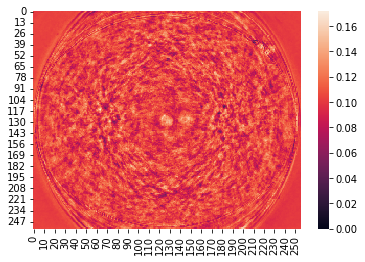

In [27]:
# Intepret the coefficients 
coef = clf.coef_
coef = coef - np.min(coef)

coef = coef.reshape( (256, 256) )

import seaborn

seaborn.heatmap(coef)
plt.savefig('log_heatmap.png')
